<a href="https://colab.research.google.com/github/myounghunseo/PowerApps-Samples/blob/master/%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89_%EC%97%B0%EC%8A%B52.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Titanic Challenge

### Part 1: 데이터 준비 및 모듈 임포트

In [3]:
# 기본 데이터 정리 및 처리
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno

# 전처리 및 머신 러닝 알고리즘
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# 모델 튜닝 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection

# 경고 제거 (판다스가 에러 메세지를 자주 만들어 내기 때문에 이를 일단 무시하도록 설정합니다.)
import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

#### CSV to DF

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/titanic/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/titanic/train.csv')

In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test.shape

(418, 11)

In [7]:
train.shape

(891, 12)

In [10]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Sage, Mr. Douglas Bullen",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### DataFrame 구조

<img src="http://bookdata.readthedocs.io/en/latest/_images/base_01_pandas_5_0.png">

### Part 2: 파일 병합

* ntrain과 ntest의 shape을 확보해놓습니다. (병합 한 것을 나중에 다시 갈라 놓기 위한 준비)
* y_train은 알려진 결과 값이니 따로 모셔 놓고
* 테스트의 승객 아이디는 나중에 최종 결과에 넣을 것이기 때문에 따로 떼어 놓습니다.
* train과 test를 병합하여 data 란 파일을 만듭니다. 문자로 된 것을 숫자로 바꾼다든가. 숫자를 인터발 별로 그룹화 한다든가 할 때 한꺼번에 하기 위해 합해 놓습니다.

In [29]:
# 병합준비
 
ntrain = train.shape[0]
ntest = test.shape[0]

 # 아래는 따로 잘 모셔 둡니다.
y_train = train['Survived'].values
passId = test['PassengerId']

 # 병합 파일 
data = pd.concat((train, test))

data.shape

(1309, 12)

### Part 3: 파일 탐색

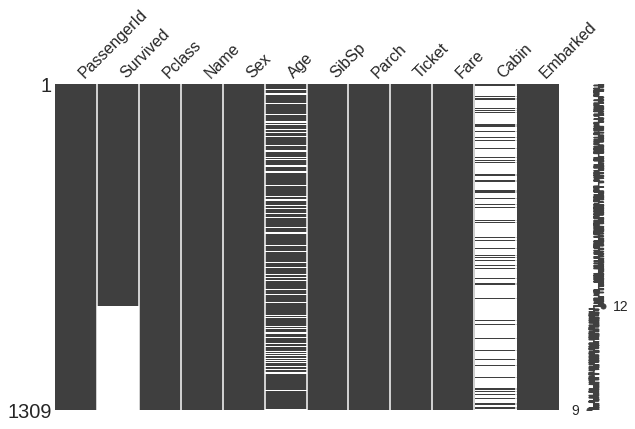

In [30]:
missingno.matrix(data, figsize=(10,6))

In [31]:
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

### Part 4: 데이터 탐구 (Exploratory Data Analysis)

In [32]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [36]:
train.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

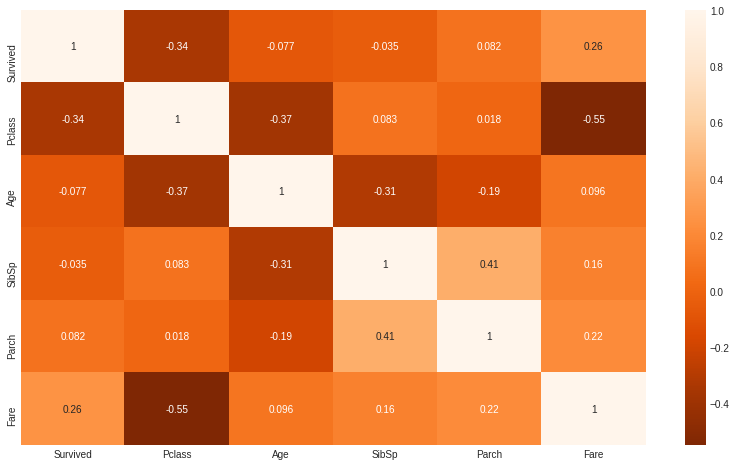

In [43]:
plt.figure(figsize=(14,8))
sns.heatmap(train[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), annot=True, cmap='Oranges_r') 

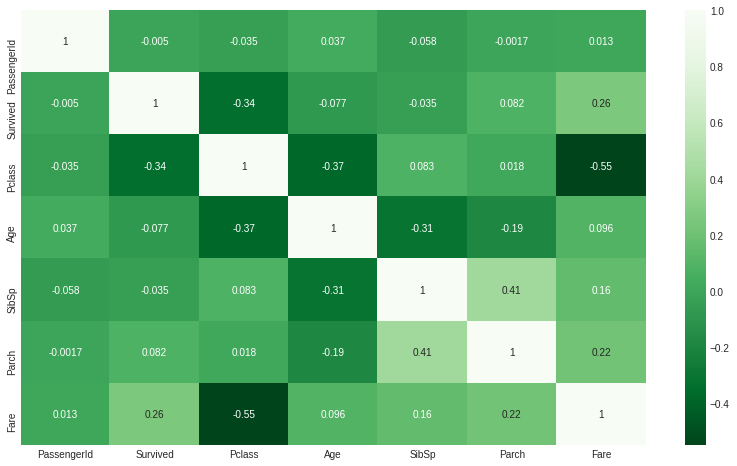

In [44]:
plt.figure(figsize=(14,8))
sns.heatmap(train.corr(), annot=True, cmap='Greens_r')
plt.show()

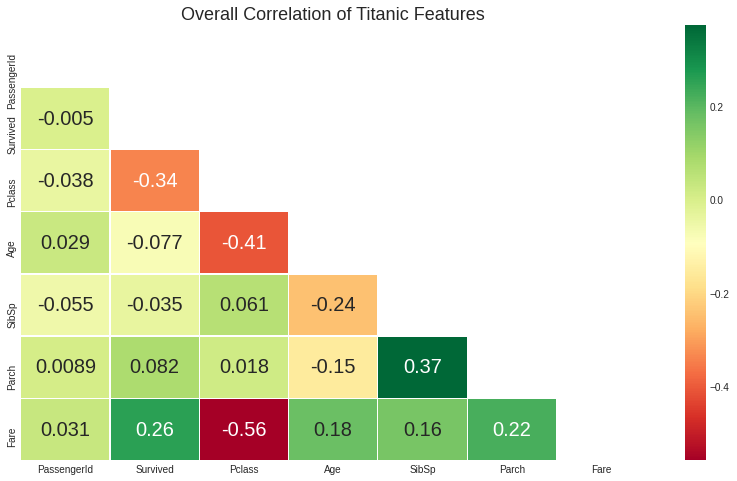

In [45]:
# Co-relation 매트릭스
corr = data.corr()
# 마스크 셋업
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 그래프 셋업
plt.figure(figsize=(14, 8))
# 그래프 타이틀
plt.title('Overall Correlation of Titanic Features', fontsize=18)
#  Co-relation 매트릭스 런칭
sns.heatmap(corr, mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

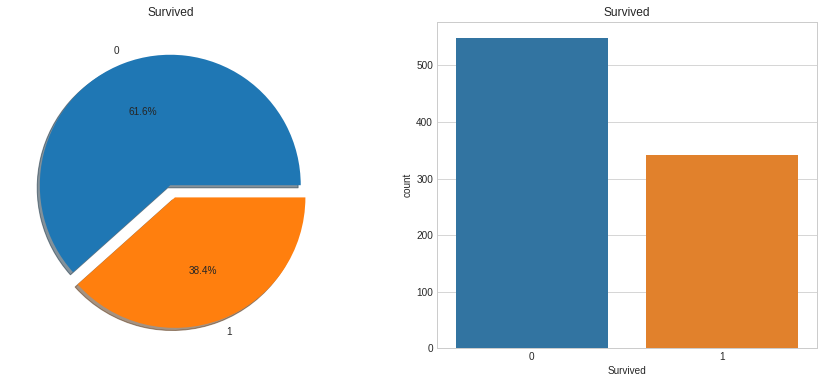

In [46]:
f,ax=plt.subplots(1, 2, figsize=(15, 6))
train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=train, ax=ax[1])
ax[1].set_title('Survived')
plt.show()

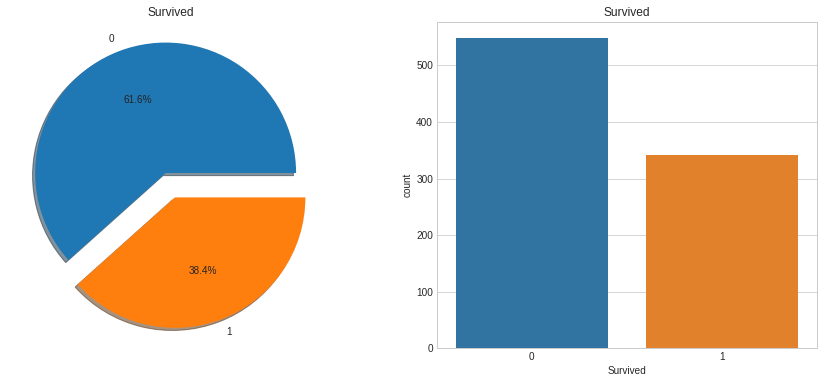

In [48]:
def piecount(col):
    f, ax = plt.subplots(1, 2, figsize=(15, 6))
    train[col].value_counts().plot.pie(explode=[0.1 for i in range(train[col].nunique())], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(col)
    ax[0].set_ylabel('')
    sns.countplot(col, data=train, ax=ax[1])
    ax[1].set_title(col)
    plt.show()

piecount('Survived')

In [49]:
train.groupby(['Pclass', 'Survived'])['Survived'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

In [53]:
pd.crosstab(train.Pclass, train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [20]:
pd.crosstab(train.Pclass, train.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


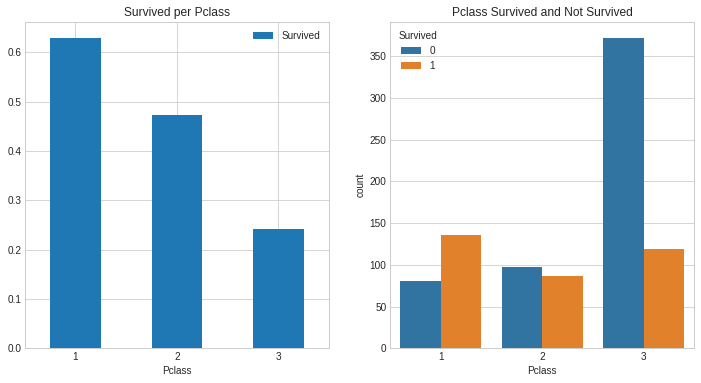

In [21]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
train[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar(ax = ax[0], rot=0)
ax[0].set_title('Survived per Pclass')
sns.countplot('Pclass', hue='Survived', data=train, ax=ax[1])
ax[1].set_title('Pclass Survived and Not Survived')
plt.show()

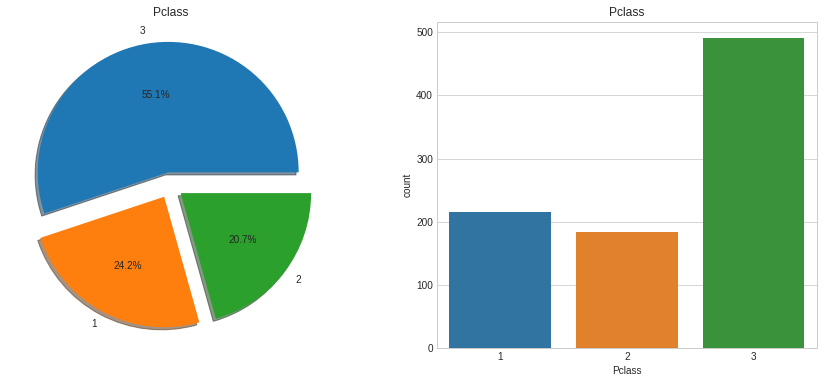

In [67]:
piecount('Pclass')

#### Name 분석

In [68]:
data.Name.value_counts()

Connolly, Miss. Kate                      2
Kelly, Mr. James                          2
Sage, Mr. Douglas Bullen                  1
Bissette, Miss. Amelia                    1
Vander Cruyssen, Mr. Victor               1
                                         ..
Yousif, Mr. Wazli                         1
Hiltunen, Miss. Marta                     1
Attalah, Mr. Sleiman                      1
Andersson, Miss. Ebba Iris Alfrida        1
Laroche, Mr. Joseph Philippe Lemercier    1
Name: Name, Length: 1307, dtype: int64

In [72]:
temp = data.copy()
temp['Initial'] = 0
temp['Initial'] = data.Name.str.extract('([A-Za-z0-9]+)\.')

In [73]:
temp.Initial.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Ms            2
Mlle          2
Major         2
Jonkheer      1
Dona          1
Mme           1
Lady          1
Don           1
Capt          1
Sir           1
Countess      1
Name: Initial, dtype: int64

In [74]:
pd.crosstab(temp.Sex, temp.Initial)

Initial,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [80]:
# 생존율 확인
# 생존율 함수 만들기

def survpct(col):
    return temp.groupby(col)['Survived'].mean()

survpct('Initial')

Initial
Capt        0.000000
Col         0.500000
Countess    1.000000
Don         0.000000
Dona             NaN
Dr          0.428571
Jonkheer    0.000000
Lady        1.000000
Major       0.500000
Master      0.575000
Miss        0.697802
Mlle        1.000000
Mme         1.000000
Mr          0.156673
Mrs         0.792000
Ms          1.000000
Rev         0.000000
Sir         1.000000
Name: Survived, dtype: float64

In [28]:
temp[temp['Initial']=='Dona']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C,Dona


In [85]:
temp.loc[temp['Initial'] == 'Dona', 'Initial'] = 'Mrs'

In [86]:
temp['LastName'] = data.Name.str.extract('([A-Za-z]+)')

In [87]:
pd.crosstab(temp.Survived, temp.LastName)

LastName,Abbing,Abbott,Abelson,Adahl,Adams,Ahlin,Aks,Albimona,Alexander,Alhomaki,Ali,Allen,Allison,Allum,Andersen,Anderson,Andersson,Andreasson,Andrew,Andrews,Angle,Appleton,Arnold,Artagaveytia,Asim,Asplund,Astor,Attalah,Aubart,Augustsson,Ayoub,Backstrom,Baclini,Badt,Bailey,Balkic,Ball,Banfield,Barah,Barbara,...,Vande,Vanden,Vander,Vestrom,Vovk,Waelens,Walker,Ward,Warren,Watson,Watt,Webber,Weir,Weisz,Wells,West,Wheadon,White,Wick,Widegren,Widener,Wiklund,Wilhelms,Willey,Williams,Windelov,Wiseman,Woolner,Wright,Yasbeck,Young,Youseff,Yousif,Yousseff,Yrois,Zabour,Zimmerman,de,del,van
Survived,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,1,1,1,1,1,1,0,0,1,1,2,1,2,1,0,0,7,1,1,1,0,0,2,1,1,1,0,2,0,1,0,1,0,1,1,1,0,1,0,2,...,2,1,4,1,1,1,1,0,0,1,0,1,1,0,0,1,1,2,0,1,1,1,0,1,4,1,1,0,1,1,0,1,1,1,1,2,1,1,1,2
1.0,0,1,1,0,0,0,1,1,0,0,0,1,1,0,1,1,2,0,0,1,1,1,0,0,0,3,1,0,1,0,1,1,4,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,2,0,0,2,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,2,0,0


In [88]:
temp['NumName'] = temp['LastName'].factorize()[0]

In [93]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [94]:
pd.crosstab(temp.Survived, temp.NumName)

NumName,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651
Survived,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,2,0,0,1,1,2,1,4,3,1,0,0,1,7,1,0,5,4,4,0,1,0,0,0,1,1,2,5,1,1,0,0,1,2,1,0,1,0,1,2,...,1,0,1,0,0,1,1,0,1,1,0,0,1,1,0,1,1,1,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,1,1,1,0,1
1.0,0,1,1,1,1,1,0,0,3,1,2,1,0,2,0,1,0,1,0,1,0,1,1,1,3,0,2,4,0,0,1,1,0,1,1,1,0,2,0,0,...,0,1,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,0,0,1,0


In [95]:
temp[temp['NumName'] == 27]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Miss,O,27
47,48,1.0,3,"O'Driscoll, Miss. Bridget",female,NaN,0,0,14311,7.7500,NaN,Q,Miss,O,27
186,187,1.0,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q,Mrs,O,27
364,365,0.0,3,"O'Brien, Mr. Thomas",male,NaN,1,0,370365,15.5000,NaN,Q,Mr,O,27
459,460,0.0,3,"O'Connor, Mr. Maurice",male,NaN,0,0,371060,7.7500,NaN,Q,Mr,O,27
502,503,0.0,3,"O'Sullivan, Miss. Bridget Mary",female,NaN,0,0,330909,7.6292,NaN,Q,Miss,O,27
552,553,0.0,3,"O'Brien, Mr. Timothy",male,NaN,0,0,330979,7.8292,NaN,Q,Mr,O,27
629,630,0.0,3,"O'Connell, Mr. Patrick D",male,NaN,0,0,334912,7.7333,NaN,Q,Mr,O,27
653,654,1.0,3,"O'Leary, Miss. Hanora ""Norah""",female,NaN,0,0,330919,7.8292,NaN,Q,Miss,O,27
88,980,NaN,3,"O'Donoghue, Ms. Bridget",female,NaN,0,0,364856,7.7500,NaN,Q,Ms,O,27


#### Sex 분석

In [35]:
train[['Sex','Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


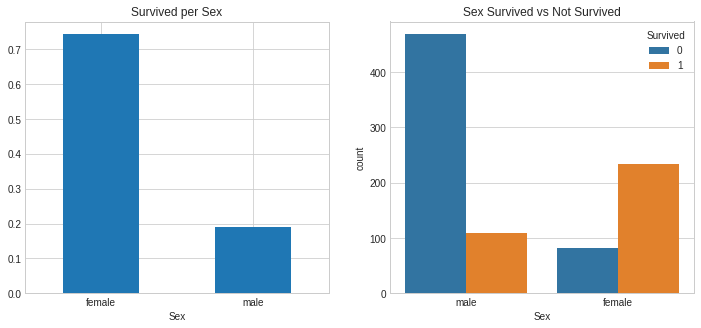

In [108]:
def bag(col, target, title, title1):
    f, ax = plt.subplots(1, 2, figsize=(12,5))
    train.groupby([col])[target].mean().plot(kind='bar', ax=ax[0], rot=0)
    ax[0].set_title(title)
    sns.countplot(col, hue=target, data=train, ax = ax[1])
    ax[1].set_title(title1)
    plt.show()

bag('Sex', 'Survived', 'Survived per Sex', 'Sex Survived vs Not Survived')


In [37]:
pd.crosstab([train.Sex, train.Survived], train.Pclass, margins=True)

Pclass             1    2    3  All
Sex    Survived                    
female 0           3    6   72   81
       1          91   70   72  233
male   0          77   91  300  468
       1          45   17   47  109
All              216  184  491  891

In [38]:
temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,3
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,4


#### Age 분석
 
* Age는 Continuous한 값입니다.
* 빈칸이 많아서 빈칸처리가 결정적인 역할을 할 것 같습니다.
 
* Age의 최대, 최소, 중간을 보겠습니다.

In [39]:
temp.Age.isnull().sum()

263

In [121]:
temp.Age.mean()   # max(), min()

29.881137667304014

In [41]:
temp['Age'].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

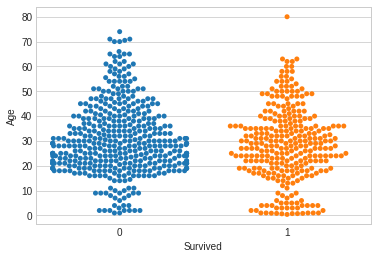

In [125]:
sns.swarmplot(x=train['Survived'], y=train['Age'])
plt.xlabel('Survived')
plt.ylabel('Age')
plt.show()

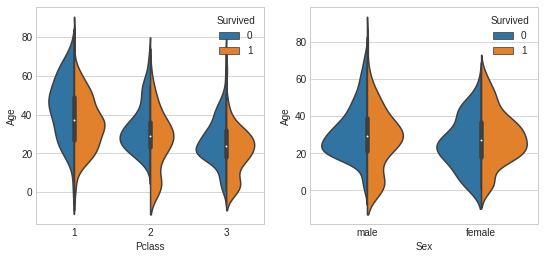

In [128]:
f, ax = plt.subplots(1,2, figsize=(9,4))
sns.violinplot('Pclass','Age', data=train, hue='Survived', split=True, ax=ax[0])
sns.violinplot('Sex','Age', data=train, hue='Survived', split=True, ax=ax[1])

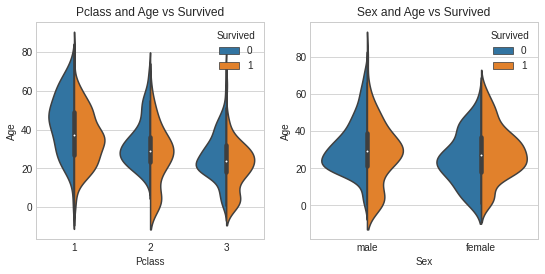

In [132]:
f, ax = plt.subplots(1, 2, figsize=(9,4))
sns.violinplot('Pclass', 'Age', data=train, hue='Survived', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
# ax[0].set_yticks(range(0,110,10))
sns.violinplot('Sex', 'Age', hue='Survived', data=train, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
# ax[1].set_yticks(range(0,80,10))
plt.show()

In [141]:
# temp.groupby('Initial')['Age'].mean()
temp.groupby('Initial').agg({'Age':['mean', 'count']}) 

Age      
               mean count
Initial                  
Capt      70.000000     1
Col       54.000000     4
Countess  33.000000     1
Don       40.000000     1
Dr        43.571429     7
Jonkheer  38.000000     1
Lady      48.000000     1
Major     48.500000     2
Master     5.482642    53
Miss      21.774238   210
Mlle      24.000000     2
Mme       24.000000     1
Mr        32.252151   581
Mrs       37.005848   171
Ms        28.000000     1
Rev       41.250000     8
Sir       49.000000     1

In [142]:
temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,3
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,4


In [143]:
temp.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr,Spector,850
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Mrs,Oliva,851
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr,Saether,852
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Mr,Ware,799
417,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,Master,Peter,116


In [144]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [145]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [150]:
temp = temp.reset_index(drop=True)

In [151]:
temp['Age'].isnull()==True

0       False
1       False
2       False
3       False
4       False
        ...  
1304     True
1305    False
1306    False
1307     True
1308     True
Name: Age, Length: 1309, dtype: bool

In [152]:
temp[temp['Age'].isnull()==True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr,Moran,5
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,Mr,Williams,17
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,Mrs,Masselmani,19
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,Mr,Emir,25
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Miss,O,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q,Miss,Riordan,847
1301,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q,Miss,Naughton,848
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr,Spector,850
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Mr,Ware,799


In [50]:
temp['Age'] = temp.groupby('Initial')['Age'].apply(lambda x : x.fillna(x.mean()))

In [167]:
temp.drop('Age2', axis=1, inplace=True)

KeyError: ignored

In [51]:
temp[temp['Age'].isnull()==True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName


In [168]:
temp['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [52]:
temp['Initial'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dona' , 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master',  'Miss'  ,'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir'], ['Sacrificed', 'Respected', 'Nobles', 'Mr', 'Mrs', 'Respected', 'Mr', 'Nobles', 'Respected', 'Kids', 'Miss', 'Nobles', 'Nobles', 'Mr', 'Mrs', 'Nobles', 'Sacrificed', 'Nobles'],inplace=True)
temp['Initial'].replace(['Kids', 'Miss', 'Mr', 'Mrs', 'Nobles', 'Respected', 'Sacrificed'], [4, 4, 2, 5, 6, 3, 1], inplace=True)

In [171]:
ls1 = ['Capt', 'Col', 'Countess', 'Don', 'Dona' , 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master',  'Miss'  ,'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir']
ls2 = ['Sacrificed', 'Respected', 'Nobles', 'Mr', 'Mrs', 'Respected', 'Mr', 'Nobles', 'Respected', 'Kids', 'Miss', 'Nobles', 'Nobles', 'Mr', 'Mrs', 'Nobles', 'Sacrificed', 'Nobles'] 

array(['Kids', 'Miss', 'Mr', 'Mrs', 'Nobles', 'Respected', 'Sacrificed'],
      dtype='<U10')

0       (16.136, 24.119]
1       (32.102, 40.085]
2       (24.119, 32.102]
3       (32.102, 40.085]
4       (32.102, 40.085]
              ...       
1304                 NaN
1305    (32.102, 40.085]
1306    (32.102, 40.085]
1307                 NaN
1308                 NaN
Name: Age, Length: 1309, dtype: category
Categories (10, interval[float64]): [(0.0902, 8.153] < (8.153, 16.136] < (16.136, 24.119] <
                                     (24.119, 32.102] ... (48.068, 56.051] < (56.051, 64.034] <
                                     (64.034, 72.017] < (72.017, 80.0]]

In [174]:
temp['Age_Range'] = pd.qcut(temp['Age'], 10)
temp['Age_Range1'] = pd.cut(temp['Age'], 10)

In [177]:
temp['Age_Range'].value_counts().sort_index()

(0.169, 14.0]    107
(14.0, 19.0]     118
(19.0, 22.0]     108
(22.0, 25.0]     110
(25.0, 28.0]      93
(28.0, 31.0]      98
(31.0, 36.0]     121
(36.0, 42.0]      96
(42.0, 50.0]     100
(50.0, 80.0]      95
Name: Age_Range, dtype: int64

In [58]:
temp['Age_Range1'].value_counts().sort_index()

(0.0902, 8.153]      80
(8.153, 16.136]      62
(16.136, 24.119]    324
(24.119, 32.102]    251
(32.102, 40.085]    364
(40.085, 48.068]    109
(48.068, 56.051]     65
(56.051, 64.034]     41
(64.034, 72.017]     10
(72.017, 80.0]        3
Name: Age_Range1, dtype: int64

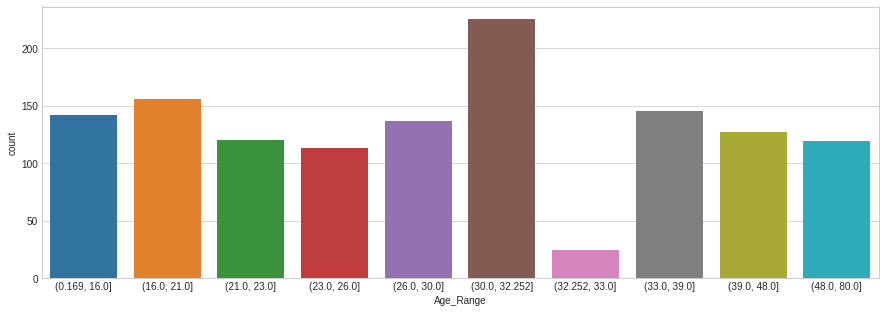

In [59]:
plt.figure(figsize=(15,5))
sns.countplot('Age_Range', data=temp)

Text(0.5, 1.0, 'cut check')

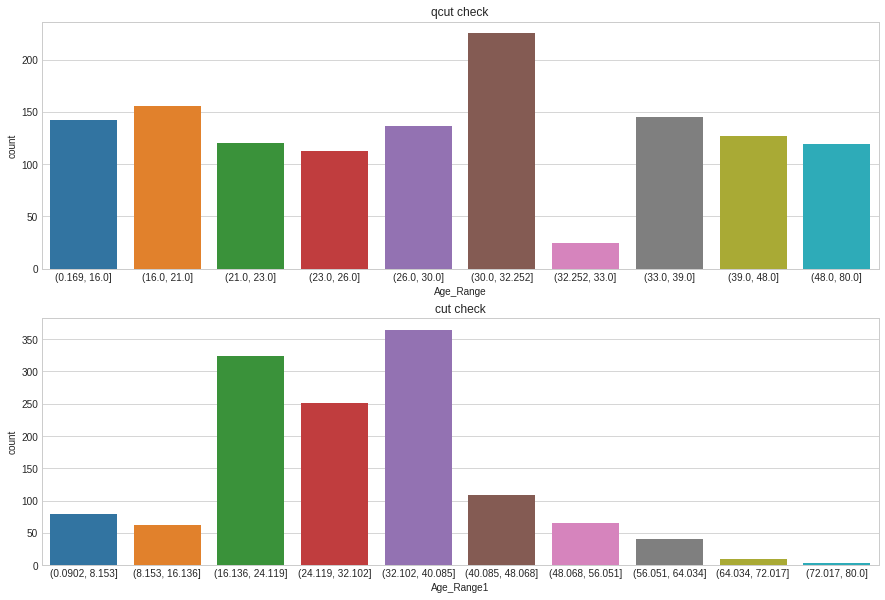

In [60]:
f, ax = plt.subplots(2,1, figsize=(15,10))
sns.countplot('Age_Range', data=temp, ax=ax[0])
ax[0].set_title('qcut check')
sns.countplot('Age_Range1',data=temp, ax=ax[1])
ax[1].set_title('cut check')

In [180]:
temp.drop('Age_Range1', axis=1, inplace=True)

In [186]:
temp['Agroup'] = 0

temp.loc[temp['Age'] < 1.0, 'Agroup'] = 1
temp.loc[(temp['Age'] >=1.0) & (temp['Age'] <= 3.0), 'Agroup'] = 2
temp.loc[(temp['Age'] > 3.0) & (temp['Age'] < 11.0), 'Agroup'] = 7
temp.loc[(temp['Age'] >= 11.0) & (temp['Age'] < 15.0), 'Agroup'] = 13
temp.loc[(temp['Age'] >= 15.0) & (temp['Age'] < 18.0), 'Agroup'] = 16
temp.loc[(temp['Age'] >= 18.0) & (temp['Age'] <=  20.0), 'Agroup'] = 18
temp.loc[(temp['Age'] > 20.0) & (temp['Age'] <= 22.0), 'Agroup'] = 21
temp.loc[(temp['Age'] > 22.0) & (temp['Age'] <= 26.0), 'Agroup'] = 24
temp.loc[(temp['Age'] > 26.0) & (temp['Age'] <= 30.0), 'Agroup'] = 28
temp.loc[(temp['Age'] > 30.0) & (temp['Age'] <= 32.0), 'Agroup'] = 31
temp.loc[(temp['Age'] > 32.0) & (temp['Age'] <= 34.0), 'Agroup'] = 33
temp.loc[(temp['Age'] > 34.0) & (temp['Age'] <= 38.0), 'Agroup'] = 36
temp.loc[(temp['Age'] > 38.0) & (temp['Age'] <= 52.0), 'Agroup'] = 45
temp.loc[(temp['Age'] > 52.0) & (temp['Age'] <= 75.0), 'Agroup'] = 60
temp.loc[temp['Age'] > 75.0, 'Agroup'] = 78

In [187]:
temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName,Age_Range,Agroup
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,0,"(19.0, 22.0]",21
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,1,"(36.0, 42.0]",36
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,2,"(25.0, 28.0]",24
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,3,"(31.0, 36.0]",36
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,4,"(31.0, 36.0]",36


In [188]:
temp[['Age_Range','Agroup']].sample(20).sort_values(by='Agroup')

,Age_Range,Agroup
82,NaN,0
563,NaN,0
538,NaN,0
260,NaN,0
778,NaN,0
407,"(0.169, 14.0]",2
220,"(14.0, 19.0]",16
311,"(14.0, 19.0]",18
682,"(19.0, 22.0]",18
794,"(22.0, 25.0]",24


In [190]:
# Sex 를 남, 여, 1세 이하 => 1,2,3

temp.loc[temp['Sex']=='male', 'Sex'] = 1
temp.loc[temp['Sex']=='female', 'Sex'] = 2
temp.loc[temp['Age']<1, 'Sex'] = 3

In [192]:
survpct('Sex')

Sex
1    0.181818
2    0.740385
3    1.000000
Name: Survived, dtype: float64

In [193]:
temp['Sex'].value_counts()

1    835
2    462
3     12
Name: Sex, dtype: int64

#### Family or Alone?
* "SibSp" + "Parch" 분석
 
* SibSp - 이 항목은 탑승자가 혼자인지 또는 가족과 함께 있는지를 나타냅니다.
* *Sibling = 형제, 자매, 의붓 형제, 이복 누이
 
* Spouse = 남편, 아내
 
* Parch는 부모와 함께 탔는지를 봅니다.
 
* 이 그룹 둘을 'Alone"그룹과 "Family'그룹으로 나눕니다.

In [194]:
temp['Alone']

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Initial', 'LastName',
       'NumName', 'Age_Range', 'Agroup'],
      dtype='object')

In [195]:
temp.loc[ (temp['SibSp'] == 0 ) & (temp['Parch'] ==0), 'Alone'  ] = 1
temp['Family'] = temp['SibSp'] + temp['Parch'] + 1

temp.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName,Age_Range,Agroup,Alone,Family
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,0,"(19.0, 22.0]",21,NaN,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,1,"(36.0, 42.0]",36,NaN,2
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,2,"(25.0, 28.0]",24,1.0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,3,"(31.0, 36.0]",36,NaN,2
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,4,"(31.0, 36.0]",36,1.0,1
5,6,0.0,3,"Moran, Mr. James",1,NaN,0,0,330877,8.4583,NaN,Q,Mr,Moran,5,NaN,0,1.0,1
6,7,0.0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,E46,S,Mr,McCarthy,6,"(50.0, 80.0]",60,1.0,1
7,8,0.0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,NaN,S,Master,Palsson,7,"(0.169, 14.0]",2,NaN,5
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,27.0,0,2,347742,11.1333,NaN,S,Mrs,Johnson,8,"(25.0, 28.0]",28,NaN,3
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",2,14.0,1,0,237736,30.0708,NaN,C,Mrs,Nasser,9,"(0.169, 14.0]",13,NaN,2


In [196]:
survpct('Family')

Family
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

In [70]:
temp['Family'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family, dtype: int64

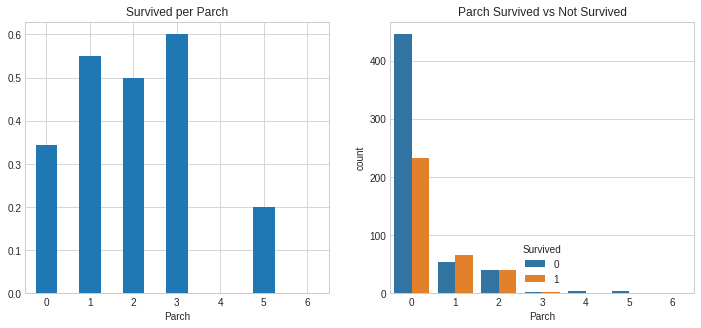

In [197]:
bag('Parch','Survived','Survived per Parch', 'Parch Survived vs Not Survived')

In [198]:
pd.crosstab([temp.Family, temp.Survived], temp.Pclass, margins=True).style.background_gradient(cmap='summer_r')

#### Ticket 분석

In [201]:
temp.Ticket.sample(10)

293        349236
438         19950
1151       345572
19           2649
1245    C.A. 2315
792      CA. 2343
777        364516
894        315154
25         347077
638       3101295
Name: Ticket, dtype: object

In [202]:
temp.Ticket.isnull().sum()

0

In [203]:
temp['Initick'] = temp.Ticket.str.extract('^([A-Za-z0-9]+)')

In [204]:
temp['Initick'] = temp.Ticket.str.extract('^([A-Za-z]+)')

In [205]:
temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName,Age_Range,Agroup,Alone,Family,Initick
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,0,"(19.0, 22.0]",21,NaN,2,A
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,1,"(36.0, 42.0]",36,NaN,2,PC
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,2,"(25.0, 28.0]",24,1.0,1,STON
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,3,"(31.0, 36.0]",36,NaN,2,NaN
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,4,"(31.0, 36.0]",36,1.0,1,NaN


In [206]:
temp['NumTicket'] = temp['Initick'].factorize()[0]

In [207]:
temp.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,0,"(19.0, 22.0]",21,NaN,2,A,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,1,"(36.0, 42.0]",36,NaN,2,PC,1
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,2,"(25.0, 28.0]",24,1.0,1,STON,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,3,"(31.0, 36.0]",36,NaN,2,NaN,-1
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,4,"(31.0, 36.0]",36,1.0,1,NaN,-1
5,6,0.0,3,"Moran, Mr. James",1,NaN,0,0,330877,8.4583,NaN,Q,Mr,Moran,5,NaN,0,1.0,1,NaN,-1
6,7,0.0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,E46,S,Mr,McCarthy,6,"(50.0, 80.0]",60,1.0,1,NaN,-1
7,8,0.0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,NaN,S,Master,Palsson,7,"(0.169, 14.0]",2,NaN,5,NaN,-1
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,27.0,0,2,347742,11.1333,NaN,S,Mrs,Johnson,8,"(25.0, 28.0]",28,NaN,3,NaN,-1
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",2,14.0,1,0,237736,30.0708,NaN,C,Mrs,Nasser,9,"(0.169, 14.0]",13,NaN,2,NaN,-1


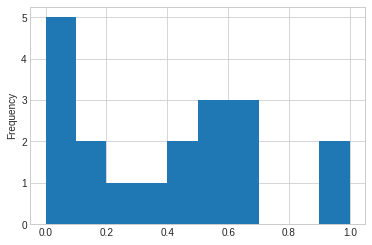

In [80]:
temp.groupby('NumTicket')['Survived'].mean().plot(kind='hist')

In [81]:
temp.groupby('NumTicket')['Survived'].mean().sort_values()

NumTicket
 15    0.000000
 11    0.000000
 0     0.068966
 7     0.071429
 9     0.090909
 10    0.117647
 6     0.142857
 12    0.250000
-1     0.384266
 2     0.444444
 4     0.454545
 17    0.500000
 16    0.500000
 5     0.538462
 1     0.650000
 3     0.666667
 13    0.666667
 14    1.000000
 8     1.000000
 18         NaN
 19         NaN
Name: Survived, dtype: float64

#### Fare 분석

In [208]:
temp.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

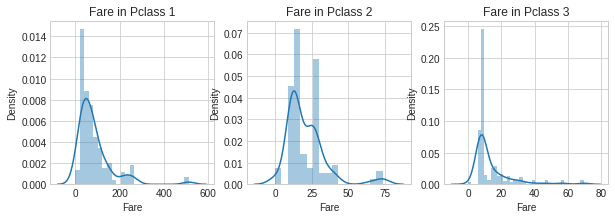

In [210]:
f, ax = plt.subplots(1,3, figsize=(10,3))
sns.distplot(train[train['Pclass'] == 1].Fare, ax=ax[0])
ax[0].set_title('Fare in Pclass 1')
sns.distplot(train[train['Pclass'] == 2].Fare, ax=ax[1])
ax[1].set_title('Fare in Pclass 2')
sns.distplot(train[train['Pclass'] == 3].Fare, ax=ax[2])
ax[2].set_title('Fare in Pclass 3')
plt.show()

* Pclass1의 승객 요금에는 큰 분포가있는 것으로 보이며 불연속 값으로 변환 할 수 있습니다.
* Fare를 그룹으로 나누어 놓겠습니다.
* qcut을 활용하면 원하는 조각으로 데이터를 나누어 줍니다.
* cut와 qcut의 차이

In [211]:
def groupmean(a, b):
    return temp.groupby([a])[b].mean().to_frame().style.background_gradient(cmap='summer_r')

temp['Fare_Range'] = pd.qcut(train['Fare'], 10)
groupmean('Fare_Range', 'Fare')

,Fare
Fare_Range,
"(-0.001, 7.55]",5.928717
"(7.55, 7.854]",7.768490
"(7.854, 8.05]",7.963669
"(8.05, 10.5]",9.521367
"(10.5, 14.454]",12.940231
"(14.454, 21.679]",17.386408
"(21.679, 27.0]",25.487501
"(27.0, 39.688]",32.282186
"(39.688, 77.958]",59.444572


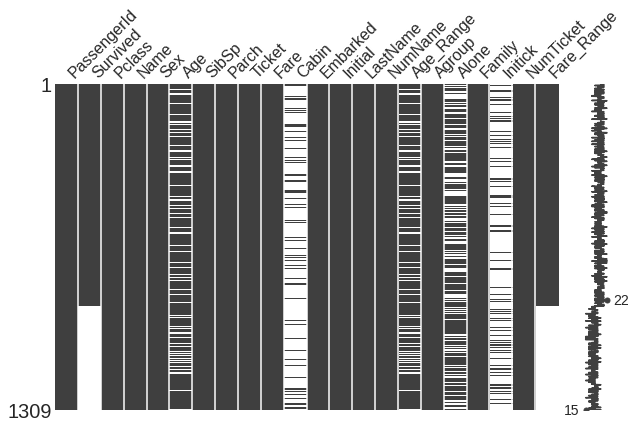

In [212]:
missingno.matrix(temp, figsize=(10,6))

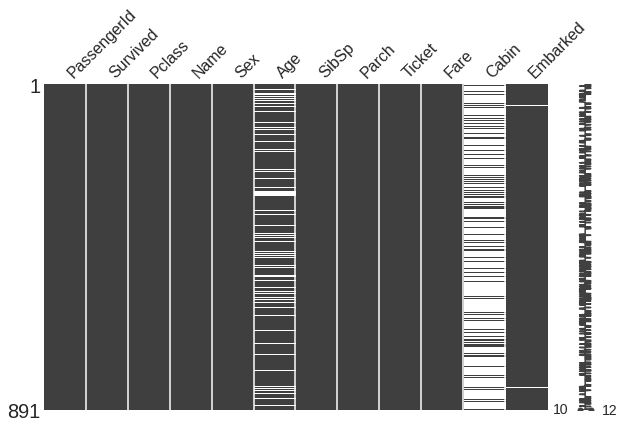

In [86]:
missingno.matrix(train, figsize=(10,6))

* Fare를 그룹화 시킵니다. Fgroup이라고 이름 짓겠습니다.

0 and below -> 0

7.125 and below-> 5.0

7.9 and below-> 7.5

8.03 or less-> 8.0

Less than 10.5-> 9.5

Less than 23-> 16.0

27.8 and below-> 25.5

51 and below-> 38

73.5 and below-> 62

Over 73.5-> 100

In [213]:
temp['Fgroup'] = 0

temp.loc[temp['Fare'] <= 0,'Fgroup'] = 0
temp.loc[(temp['Fare'] > 0) & (temp['Fare'] <= 7.125), 'Fgroup'] = 1
temp.loc[(temp['Fare'] > 7.125) & (temp['Fare'] <= 7.9), 'Fgroup'] = 2
temp.loc[(temp['Fare'] > 7.9) & (temp['Fare'] <= 8.03), 'Fgroup'] = 3
temp.loc[(temp['Fare'] > 8.03) & (temp['Fare'] < 10.5), 'Fgroup'] = 4
temp.loc[(temp['Fare'] >= 10.5) & (temp['Fare'] < 23.0), 'Fgroup'] = 5
temp.loc[(temp['Fare'] >= 23.0) & (temp['Fare'] <= 27.8), 'Fgroup'] = 6
temp.loc[(temp['Fare'] > 27.8) & (temp['Fare'] <= 51.0), 'Fgroup'] = 7
temp.loc[(temp['Fare'] > 51.0) & (temp['Fare'] <= 73.5), 'Fgroup'] = 8
temp.loc[temp['Fare'] > 73.5, 'Fgroup'] = 9

temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,0,"(19.0, 22.0]",21,NaN,2,A,0,"(-0.001, 7.55]",2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,1,"(36.0, 42.0]",36,NaN,2,PC,1,"(39.688, 77.958]",8
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,2,"(25.0, 28.0]",24,1.0,1,STON,2,"(7.854, 8.05]",3
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,3,"(31.0, 36.0]",36,NaN,2,NaN,-1,"(39.688, 77.958]",8
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,4,"(31.0, 36.0]",36,1.0,1,NaN,-1,"(7.854, 8.05]",4


#### Cabin 분석
* cabin 의 위치에 따라 달라지는 것이 있는지 보겠습니다.

In [214]:
temp.Cabin.isnull().sum()

1014

In [215]:
temp.Cabin.value_counts()

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
F33                4
F4                 4
                  ..
D49                1
B39                1
A6                 1
B101               1
C103               1
Name: Cabin, Length: 186, dtype: int64

* 빈칸이 무척 많습니다.
* Cabin에 비어 있는 것이 많아 이를 다른 분류로 일단 잡고 기존 것은 이니셜로 분류합니다.
* 빈 것은 X로 구분하려는데 이 또한 1,2,3 Pclass와 연동될 것 같으니 비어있고 1등급은 X, 2등급은 Y, 3등급은 Z로 하겠습니다.

In [216]:
temp['Inicab'] = 0
temp['Inicab'] = temp['Cabin'].str.extract('^([A-Za-z]+)')
temp.loc[((temp['Cabin'].isnull()) & (temp['Pclass'].values == 1)), 'Inicab'] = 'X'
temp.loc[((temp['Cabin'].isnull()) & (temp['Pclass'].values == 2)), 'Inicab'] = 'Y'
temp.loc[((temp['Cabin'].isnull()) & (temp['Pclass'].values == 3)), 'Inicab'] = 'Z'
    
temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,0,"(19.0, 22.0]",21,NaN,2,A,0,"(-0.001, 7.55]",2,Z
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,1,"(36.0, 42.0]",36,NaN,2,PC,1,"(39.688, 77.958]",8,C
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,2,"(25.0, 28.0]",24,1.0,1,STON,2,"(7.854, 8.05]",3,Z
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,3,"(31.0, 36.0]",36,NaN,2,NaN,-1,"(39.688, 77.958]",8,C
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,4,"(31.0, 36.0]",36,1.0,1,NaN,-1,"(7.854, 8.05]",4,Z


In [217]:
temp['Inicab'] = temp['Inicab'].factorize()[0]
temp[11:20]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab
11,12,1.0,1,"Bonnell, Miss. Elizabeth",2,58.0,0,0,113783,26.5500,C103,S,Miss,Bonnell,11,"(50.0, 80.0]",60,1.0,1,NaN,-1,"(21.679, 27.0]",6,1
12,13,0.0,3,"Saundercock, Mr. William Henry",1,20.0,0,0,A/5. 2151,8.0500,NaN,S,Mr,Saundercock,12,"(19.0, 22.0]",18,1.0,1,A,0,"(7.854, 8.05]",4,0
13,14,0.0,3,"Andersson, Mr. Anders Johan",1,39.0,1,5,347082,31.2750,NaN,S,Mr,Andersson,13,"(36.0, 42.0]",45,NaN,7,NaN,-1,"(27.0, 39.688]",7,0
14,15,0.0,3,"Vestrom, Miss. Hulda Amanda Adolfina",2,14.0,0,0,350406,7.8542,NaN,S,Miss,Vestrom,14,"(0.169, 14.0]",13,1.0,1,NaN,-1,"(7.55, 7.854]",2,0
15,16,1.0,2,"Hewlett, Mrs. (Mary D Kingcome)",2,55.0,0,0,248706,16.0000,NaN,S,Mrs,Hewlett,15,"(50.0, 80.0]",60,1.0,1,NaN,-1,"(14.454, 21.679]",5,3
16,17,0.0,3,"Rice, Master. Eugene",1,2.0,4,1,382652,29.1250,NaN,Q,Master,Rice,16,"(0.169, 14.0]",2,NaN,6,NaN,-1,"(27.0, 39.688]",7,0
17,18,1.0,2,"Williams, Mr. Charles Eugene",1,NaN,0,0,244373,13.0000,NaN,S,Mr,Williams,17,NaN,0,1.0,1,NaN,-1,"(10.5, 14.454]",5,3
18,19,0.0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",2,31.0,1,0,345763,18.0000,NaN,S,Mrs,Vander,18,"(28.0, 31.0]",31,NaN,2,NaN,-1,"(14.454, 21.679]",5,0
19,20,1.0,3,"Masselmani, Mrs. Fatima",2,NaN,0,0,2649,7.2250,NaN,C,Mrs,Masselmani,19,NaN,0,1.0,1,NaN,-1,"(-0.001, 7.55]",2,0


#### Embarked 분석

In [220]:
pd.crosstab([temp.Embarked, temp.Pclass], [temp.Sex, temp.Survived], margins=True).style.background_gradient(cmap='summer_r')

* 승선 장소 별로 생존 확률

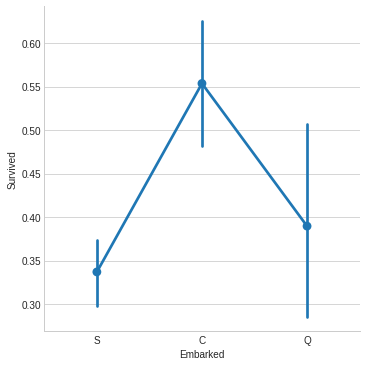

In [221]:
sns.factorplot('Embarked', 'Survived', data=temp)
plt.show()

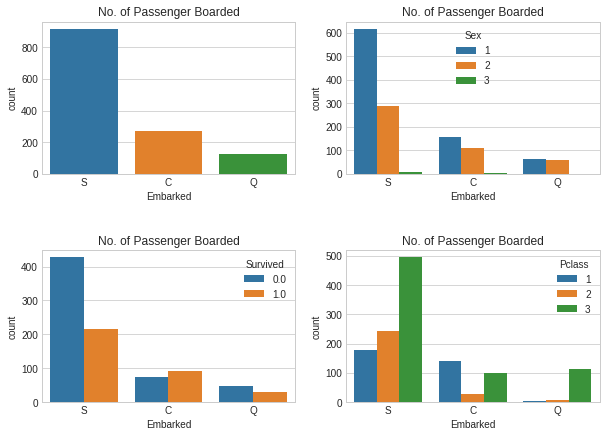

In [94]:
f, ax = plt.subplots(2,2 , figsize=(10,7))
sns.countplot('Embarked', data=temp, ax = ax[0,0])
ax[0,0].set_title('No. of Passenger Boarded')
sns.countplot('Embarked',hue='Sex', data=temp, ax = ax[0,1])
ax[0,1].set_title('No. of Passenger Boarded')
sns.countplot('Embarked', hue='Survived' ,data=temp, ax = ax[1,0])
ax[1,0].set_title('No. of Passenger Boarded')
sns.countplot('Embarked', hue='Pclass',data=temp, ax = ax[1,1])
ax[1,1].set_title('No. of Passenger Boarded')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

1) 포트 C의 생존 가능성은 0.55 정도이며 S는 가장 낮습니다.S에서 탑승 최대. 대다수는 Pclass3

2) C의 승객들은 많은 비율이 살아남았습니다. 그 이유는 Pclass1 및 Pclass2 승객이 많아서 일 것입니다

3) Embark S는 대부분의 부자들이 탑승한 항구지만 생존 가능성은 낮습니다. Pclass3의 승객도 많았습니다.

4) 포트 Q는 승객의 거의 95 %가 Pclass3

* 빈칸이 두개 있는데 보겠습니다.

In [95]:
temp.loc[temp.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab
61,62,1.0,1,"Icard, Miss. Amelie",2,38.0,0,0,113572,80.0,B28,NaN,4,Icard,58,"(33.0, 39.0]",36,1.0,1,NaN,-1,"(77.958, 512.329]",9,8
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",2,62.0,0,0,113572,80.0,B28,NaN,5,Stone,616,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(77.958, 512.329]",9,8


* 두 사람의 티켓 번호가 같습니다.
* 혹시 같은 티켓 번호가 있는 다른 사람이 있는지 봅니다.

In [96]:
temp[temp.Ticket == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab
61,62,1.0,1,"Icard, Miss. Amelie",2,38.0,0,0,113572,80.0,B28,NaN,4,Icard,58,"(33.0, 39.0]",36,1.0,1,NaN,-1,"(77.958, 512.329]",9,8
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",2,62.0,0,0,113572,80.0,B28,NaN,5,Stone,616,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(77.958, 512.329]",9,8


In [97]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     891 non-null    float64 
 2   Pclass       1309 non-null   int64   
 3   Name         1309 non-null   object  
 4   Sex          1309 non-null   object  
 5   Age          1309 non-null   float64 
 6   SibSp        1309 non-null   int64   
 7   Parch        1309 non-null   int64   
 8   Ticket       1309 non-null   object  
 9   Fare         1308 non-null   float64 
 10  Cabin        295 non-null    object  
 11  Embarked     1307 non-null   object  
 12  Initial      1309 non-null   int64   
 13  LastName     1309 non-null   object  
 14  NumName      1309 non-null   int64   
 15  Age_Range    1309 non-null   category
 16  Agroup       1309 non-null   int64   
 17  Alone        790 non-null    float64 
 18  Family       1309 non-null  

* 가장 비슷한 번호를 찾아 보겠습니다.

In [98]:
temp.sort_values(['Ticket'], ascending=True)[55:77]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab
54,55,0.0,1,"Ostby, Mr. Engelhart Cornelius",1,65.000000,0,1,113509,61.9792,B30,C,2,Ostby,51,"(48.0, 80.0]",60,NaN,2,NaN,-1,"(39.688, 77.958]",8,8
351,352,0.0,1,"Williams-Lambert, Mr. Fletcher Fellows",1,32.252151,0,0,113510,35.0000,C128,S,2,Williams,17,"(30.0, 32.252]",33,1.0,1,NaN,-1,"(27.0, 39.688]",7,1
252,253,0.0,1,"Stead, Mr. William Thomas",1,62.000000,0,0,113514,26.5500,C87,S,2,Stead,217,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(21.679, 27.0]",6,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",2,62.000000,0,0,113572,80.0000,B28,NaN,5,Stone,616,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(77.958, 512.329]",9,8
61,62,1.0,1,"Icard, Miss. Amelie",2,38.000000,0,0,113572,80.0000,B28,NaN,4,Icard,58,"(33.0, 39.0]",36,1.0,1,NaN,-1,"(77.958, 512.329]",9,8
802,803,1.0,1,"Carter, Master. William Thornton II",1,11.000000,1,2,113760,120.0000,B96 B98,S,4,Carter,215,"(0.169, 16.0]",13,NaN,4,NaN,-1,"(77.958, 512.329]",9,8
390,391,1.0,1,"Carter, Mr. William Ernest",1,36.000000,1,2,113760,120.0000,B96 B98,S,2,Carter,215,"(33.0, 39.0]",36,NaN,4,NaN,-1,"(77.958, 512.329]",9,8
435,436,1.0,1,"Carter, Miss. Lucile Polk",2,14.000000,1,2,113760,120.0000,B96 B98,S,4,Carter,215,"(0.169, 16.0]",13,NaN,4,NaN,-1,"(77.958, 512.329]",9,8
763,764,1.0,1,"Carter, Mrs. William Ernest (Lucile Polk)",2,36.000000,1,2,113760,120.0000,B96 B98,S,5,Carter,215,"(33.0, 39.0]",36,NaN,4,NaN,-1,"(77.958, 512.329]",9,8
185,186,0.0,1,"Rood, Mr. Hugh Roscoe",1,32.252151,0,0,113767,50.0000,A32,S,2,Rood,162,"(30.0, 32.252]",33,1.0,1,NaN,-1,"(39.688, 77.958]",7,6


In [99]:
temp.loc[(temp.Embarked.isnull()), 'Embarked'] ='S'

In [100]:
temp.Embarked.isnull().sum()

0

In [101]:
temp.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [102]:
temp['Embarked'] = temp['Embarked'].factorize()[0]
temp[11:20]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab
11,12,1.0,1,"Bonnell, Miss. Elizabeth",2,58.000000,0,0,113783,26.5500,C103,0,4,Bonnell,11,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(21.679, 27.0]",6,1
12,13,0.0,3,"Saundercock, Mr. William Henry",1,20.000000,0,0,A/5. 2151,8.0500,NaN,0,2,Saundercock,12,"(16.0, 21.0]",18,1.0,1,A,0,"(7.854, 8.05]",4,0
13,14,0.0,3,"Andersson, Mr. Anders Johan",1,39.000000,1,5,347082,31.2750,NaN,0,2,Andersson,13,"(33.0, 39.0]",45,NaN,7,NaN,-1,"(27.0, 39.688]",7,0
14,15,0.0,3,"Vestrom, Miss. Hulda Amanda Adolfina",2,14.000000,0,0,350406,7.8542,NaN,0,4,Vestrom,14,"(0.169, 16.0]",13,1.0,1,NaN,-1,"(7.55, 7.854]",2,0
15,16,1.0,2,"Hewlett, Mrs. (Mary D Kingcome)",2,55.000000,0,0,248706,16.0000,NaN,0,5,Hewlett,15,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(14.454, 21.679]",5,3
16,17,0.0,3,"Rice, Master. Eugene",1,2.000000,4,1,382652,29.1250,NaN,2,4,Rice,16,"(0.169, 16.0]",2,NaN,6,NaN,-1,"(27.0, 39.688]",7,0
17,18,1.0,2,"Williams, Mr. Charles Eugene",1,32.252151,0,0,244373,13.0000,NaN,0,2,Williams,17,"(30.0, 32.252]",33,1.0,1,NaN,-1,"(10.5, 14.454]",5,3
18,19,0.0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",2,31.000000,1,0,345763,18.0000,NaN,0,5,Vander,18,"(30.0, 32.252]",31,NaN,2,NaN,-1,"(14.454, 21.679]",5,0
19,20,1.0,3,"Masselmani, Mrs. Fatima",2,37.005848,0,0,2649,7.2250,NaN,1,5,Masselmani,19,"(33.0, 39.0]",36,1.0,1,NaN,-1,"(-0.001, 7.55]",2,0


### Part 5: Feature Engineering

* 문자를 숫자로 바꾸는 것도 Feature Engineering의 일부이나 위에서 대부분 다 했습니다.

* 위에 추가 항목을 몇 개 만들어 보았습니다.

* 그래도 몇 개 더 만들어 볼까요? 

* 5개 정도 만들어 봅니다.

* Priority - (1) Nobles (2) Women in Pclass 1,2 (3) Babies under 1 (4) Kids under 17 in Pclass 1 & 2  (5) High Fare / Women in Pclass 3
* FH - Female Higher Survival Group
* MH - Male Higher Survival Group
* FL - Female Lower Surival Group
* ML - Male Lower Survival Group

* Priority - (1) Nobles (2) Women in Pclass 1 (3) Babies under 1 (4) Kids under 17 in Pclass 1 & 2  (5) Women in Pclass 2 (6) Higher Fare

In [103]:
survpct('Initial')

Initial
1    0.000000
2    0.156069
3    0.454545
4    0.675676
5    0.792000
6    1.000000
Name: Survived, dtype: float64

In [104]:
survpct('Pclass')

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [105]:
survpct('Sex')

Sex
1    0.181818
2    0.740385
3    1.000000
Name: Survived, dtype: float64

In [106]:
survpct('Age').head(10)

Age
0.17         NaN
0.33         NaN
0.42    1.000000
0.67    1.000000
0.75    1.000000
0.83    1.000000
0.92    1.000000
1.00    0.714286
2.00    0.300000
3.00    0.833333
Name: Survived, dtype: float64

In [107]:
survpct('Fgroup')

Fgroup
0    0.066667
1    0.037037
2    0.232044
3    0.473684
4    0.144330
5    0.425000
6    0.489362
7    0.353535
8    0.564516
9    0.762887
Name: Survived, dtype: float64

In [108]:
temp['Priority'] = 0
temp.loc[(temp['Initial'] == 6), 'Priority'] = 1
temp.loc[(temp['Pclass'] == 1) & (temp['Sex'] == 2), 'Priority'] = 2
temp.loc[(temp['Age'] < 1), 'Priority'] = 3
temp.loc[(temp['Pclass'] == 1) & (temp['Age'] <= 17), 'Priority'] = 4
temp.loc[(temp['Pclass'] == 2) & (temp['Age'] <= 17), 'Priority'] = 5
temp.loc[(temp['Pclass'] == 2) & (temp['Sex'] == 2), 'Priority'] = 6
temp.loc[(temp['Fgroup'] == 9), 'Priority'] = 7

In [109]:
survpct('Priority')

Priority
0    0.229508
1    1.000000
2    0.965517
3    1.000000
4    1.000000
5    0.818182
6    0.921053
7    0.762887
Name: Survived, dtype: float64

In [110]:
temp.Priority.value_counts().sort_index()

0    978
1      2
2     52
3      7
4      4
5     16
6    105
7    145
Name: Priority, dtype: int64

In [111]:
survpct('Family')

Family
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

In [112]:
survpct('Fgroup')

Fgroup
0    0.066667
1    0.037037
2    0.232044
3    0.473684
4    0.144330
5    0.425000
6    0.489362
7    0.353535
8    0.564516
9    0.762887
Name: Survived, dtype: float64

In [113]:
temp['FH'] = 0
temp.loc[(temp['Sex'] == 1), 'FH'] = 0
temp.loc[(temp['Sex'] == 2), 'FH'] = 1
temp.loc[(temp['Sex'] == 2) & (temp['Family'] == 2), 'FH'] = 2
temp.loc[(temp['Sex'] == 2) & (temp['Family'] == 3), 'FH'] = 3
temp.loc[(temp['Sex'] == 2) & (temp['Family'] == 4), 'FH'] = 4
temp.loc[(temp['Sex'] == 2) & (temp['Family'] == 1) & (temp['Pclass'] == 1), 'FH'] = 5
temp.loc[(temp['Sex'] == 2) & (temp['Family'] == 1) & (temp['Pclass'] == 2), 'FH'] = 6
temp.loc[(temp['Sex'] == 2) & (temp['Fgroup'] == 3), 'FH'] = 7
temp.loc[(temp['Sex'] == 2) & (temp['Fgroup'] >= 5), 'FH'] = 8

In [114]:
survpct('FH')

FH
0    0.191710
1    0.615385
2    0.333333
3    0.000000
7    0.666667
8    0.784553
Name: Survived, dtype: float64

In [115]:
temp.FH.value_counts()

0    847
8    354
1     89
7      8
2      7
3      4
Name: FH, dtype: int64

In [116]:
temp['MH'] = 0
temp.loc[(temp['Sex'] == 2), 'MH'] = 0
temp.loc[(temp['Sex'] == 1), 'MH'] = 1
temp.loc[(temp['Sex'] == 1) & (temp['Family'] == 2), 'MH'] = 2
temp.loc[(temp['Sex'] == 1) & (temp['Family'] == 3), 'MH'] = 3
temp.loc[(temp['Sex'] == 1) & (temp['Family'] == 4), 'MH'] = 4
temp.loc[(temp['Sex'] == 1) & (temp['Family'] == 1) & (temp['Pclass'] == 1), 'MH'] = 5
temp.loc[(temp['Sex'] == 1) & (temp['Family'] == 1) & (temp['Pclass'] == 2), 'MH'] = 6
temp.loc[(temp['Sex'] == 1) & (temp['Fgroup'] == 3), 'MH'] = 7
temp.loc[(temp['Sex'] == 1) & (temp['Fgroup'] >= 5), 'MH'] = 8

In [117]:
survpct('MH')

MH
0    0.746082
1    0.094017
2    0.111111
3    0.000000
5    0.000000
6    0.000000
7    0.384615
8    0.253333
Name: Survived, dtype: float64

In [118]:
temp.MH.value_counts()

0    474
8    450
1    335
7     16
2     13
5      8
6      7
3      6
Name: MH, dtype: int64

In [119]:
temp['FL'] = 0
temp.loc[(temp['Sex'] == 1), 'FL'] = 0
temp.loc[(temp['Sex'] == 2) & (temp['Fgroup'] < 5), 'FL'] = 1
temp.loc[(temp['Sex'] == 2) & (temp['Fgroup'] != 3), 'FL'] = 2
temp.loc[(temp['Sex'] == 2) & (temp['FH'] == 1), 'FL'] = 3
temp.loc[(temp['Sex'] == 2) & (temp['Family'] < 2), 'FL'] = 4
temp.loc[(temp['Sex'] == 2) & (temp['Family'] > 4), 'FL'] = 5
temp.loc[(temp['Sex'] == 2) & (temp['Family'] == 1) & (temp['Pclass'] == 3), 'FL'] = 6

In [120]:
survpct('FL')

FL
0    0.191710
1    0.000000
2    0.809211
4    0.939394
5    0.272727
6    0.616667
Name: Survived, dtype: float64

In [121]:
temp.FL.value_counts()

0    847
2    225
6    100
4     94
5     41
1      2
Name: FL, dtype: int64

In [122]:
temp['ML'] = 0
temp.loc[(temp['Sex'] == 2), 'ML'] = 0
temp.loc[(temp['Sex'] == 1) & (temp['Fgroup'] < 5), 'ML'] = 1
temp.loc[(temp['Sex'] == 1) & (temp['Fgroup'] != 3), 'ML'] = 2
temp.loc[(temp['Sex'] == 1) & (temp['MH'] <7), 'ML'] = 3
temp.loc[(temp['Sex'] == 1) & (temp['Family'] < 2), 'ML'] = 4
temp.loc[(temp['Sex'] == 1) & (temp['Family'] > 4), 'ML'] = 5
temp.loc[(temp['Sex'] == 1) & (temp['Family'] == 1) & (temp['Pclass'] == 3), 'ML'] = 6

In [123]:
survpct('ML')

ML
0    0.746082
1    0.333333
2    0.318966
3    0.076923
4    0.217687
5    0.034483
6    0.121212
Name: Survived, dtype: float64

In [124]:
temp.ML.value_counts()

0    474
6    372
4    224
2    176
5     41
3     19
1      3
Name: ML, dtype: int64

### Part 6: 마지막 항목 결정

In [125]:
temp['F1'] = temp['Priority']
temp['F2'] = temp['FH']
temp['F3'] = temp['MH']
temp['F4'] = temp['FL']
temp['F5'] = temp['ML']
temp['F6'] = temp['Initial']
temp['F7'] = temp['Fgroup']
temp['F8'] = temp['NumName']
temp['F9'] = temp['NumTicket']
temp['F10'] = temp['Family']
temp['F11'] = temp['Embarked']
temp['F12'] = temp['Sex']
temp['F13'] = temp['Pclass']

In [126]:
temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,LastName,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab,Priority,FH,MH,FL,ML,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,2,Braund,0,"(21.0, 23.0]",21,NaN,2,A,0,"(-0.001, 7.55]",2,0,0,0,2,0,3,0,0,2,0,3,2,2,0,0,2,0,1,3
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,1,5,Cumings,1,"(33.0, 39.0]",36,NaN,2,PC,1,"(39.688, 77.958]",8,1,2,8,0,2,0,2,8,0,2,0,5,8,1,1,2,1,2,1
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,4,Heikkinen,2,"(23.0, 26.0]",24,1.0,1,STON,2,"(7.854, 8.05]",3,0,0,7,0,6,0,0,7,0,6,0,4,3,2,2,1,0,2,3
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,0,5,Futrelle,3,"(33.0, 39.0]",36,NaN,2,NaN,-1,"(39.688, 77.958]",8,1,2,8,0,2,0,2,8,0,2,0,5,8,3,-1,2,0,2,1
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,2,Allen,4,"(33.0, 39.0]",36,1.0,1,NaN,-1,"(7.854, 8.05]",4,0,0,0,1,0,6,0,0,1,0,6,2,4,4,-1,1,0,1,3


* 두개의 새로운 데이터 프레임을 만듭니다. 하나는 레이블 인코딩 다른 하나는 원핫 인코딩 (둘이 꼭 필요한 것이 아니라 연습이나 두 가지 방 법 모두 사용해봄)

In [127]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

새로운 Data Frame을 만듭니다.

In [128]:
df1 = pd.DataFrame()  # for label encoding

In [129]:
good_columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13']
df1[good_columns] = temp[good_columns]

In [130]:
df1.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,0,0,2,0,3,2,2,0,0,2,0,1,3
1,2,8,0,2,0,5,8,1,1,2,1,2,1
2,0,7,0,6,0,4,3,2,2,1,0,2,3
3,2,8,0,2,0,5,8,3,-1,2,0,2,1
4,0,0,1,0,6,2,4,4,-1,1,0,1,3


In [131]:
dfh = df1.copy()

In [132]:
df1_enc = df1.apply(LabelEncoder().fit_transform)
df1_enc.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,0,0,2,0,3,1,2,0,1,1,0,0,2
1,2,5,0,2,0,4,8,1,2,1,1,1,0
2,0,4,0,5,0,3,3,2,3,0,0,1,2
3,2,5,0,2,0,4,8,3,0,1,0,1,0
4,0,0,1,0,6,1,4,4,0,0,0,0,2


In [133]:
one_hot_cols = dfh.columns.tolist()
dfh_enc = pd.get_dummies(dfh, columns=one_hot_cols)

dfh_enc.head()

,F1_0,F1_1,F1_2,F1_3,F1_4,F1_5,F1_6,F1_7,F2_0,F2_1,F2_2,F2_3,F2_7,F2_8,F3_0,F3_1,F3_2,F3_3,F3_5,F3_6,F3_7,F3_8,F4_0,F4_1,F4_2,F4_4,F4_5,F4_6,F5_0,F5_1,F5_2,F5_3,F5_4,F5_5,F5_6,F6_1,F6_2,F6_3,F6_4,F6_5,...,F8_852,F9_-1,F9_0,F9_1,F9_2,F9_3,F9_4,F9_5,F9_6,F9_7,F9_8,F9_9,F9_10,F9_11,F9_12,F9_13,F9_14,F9_15,F9_16,F9_17,F9_18,F9_19,F10_1,F10_2,F10_3,F10_4,F10_5,F10_6,F10_7,F10_8,F10_11,F11_0,F11_1,F11_2,F12_1,F12_2,F12_3,F13_1,F13_2,F13_3
0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1


### Part 7:  머신러닝 모델 만들기

In [134]:
train = dfh_enc[:ntrain]
test = dfh_enc[ntrain:]

In [135]:
X_test = test
X_train = train

In [136]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [137]:
ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
ext = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier()

# 리스트 준비
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]
model_names = ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier']
scores = {}

# 모델 학습 and 교차 검증

for ind, mod in enumerate(models):
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring='accuracy', cv = 10)
    scores[model_names[ind]] = acc

In [138]:
# 결과 테이블 만들기
results = pd.DataFrame(scores).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)
result_df

,0,1,2,3,4,5,6,7,8,9,mean
Bagging Classifier,0.855556,0.887640,0.764045,0.887640,0.898876,0.842697,0.853933,0.786517,0.820225,0.831461,0.842859
Extra Trees,0.777778,0.876404,0.752809,0.876404,0.876404,0.865169,0.853933,0.786517,0.853933,0.820225,0.833958
XGBoost,0.833333,0.820225,0.775281,0.898876,0.853933,0.831461,0.853933,0.764045,0.853933,0.842697,0.832772
SVC,0.833333,0.887640,0.797753,0.876404,0.865169,0.797753,0.808989,0.764045,0.865169,0.820225,0.831648
Random Forest,0.777778,0.876404,0.752809,0.887640,0.887640,0.842697,0.831461,0.775281,0.853933,0.820225,0.830587
Gradient Boosting,0.811111,0.831461,0.764045,0.876404,0.865169,0.831461,0.842697,0.797753,0.831461,0.842697,0.829426
Logistic Regression,0.800000,0.853933,0.797753,0.865169,0.876404,0.808989,0.820225,0.786517,0.853933,0.820225,0.828315
AdaBoost,0.811111,0.842697,0.786517,0.865169,0.853933,0.808989,0.808989,0.786517,0.820225,0.842697,0.822684
K Nearest Neighbour,0.788889,0.808989,0.786517,0.797753,0.842697,0.786517,0.786517,0.730337,0.842697,0.831461,0.800237
Gaussian Process,0.522222,0.696629,0.539326,0.494382,0.573034,0.528090,0.426966,0.561798,0.550562,0.606742,0.549975


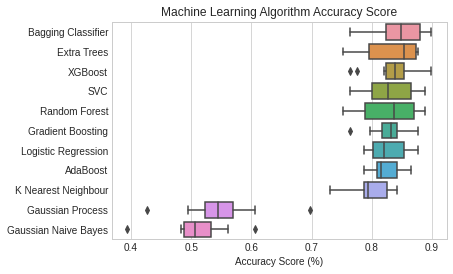

In [139]:
result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm Accuracy Score')
plt.xlabel('Accuracy Score (%)')
plt.show()

In [140]:
# 중요도 함수
def importance_plotting(data, xlabel, ylabel, title, n=20):
    sns.set(style='whitegrid')
    ax = data.tail(n).plot(kind='barh')

    ax.set(title=title, xlabel = xlabel, ylabel = ylabel)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    plt.show()

In [141]:
# 데이터 프레임에 항목 중요도를 넣습니다.
fi = {'Features':train.columns.tolist(), 'Importance':xgb.feature_importances_}
importance = pd.DataFrame(fi, index=fi['Features']).sort_values('Importance',ascending=True)

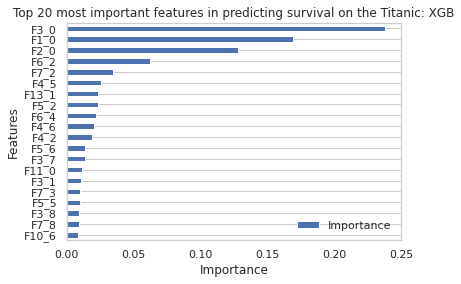

In [142]:
# 그래프 제목
title = 'Top 20 most important features in predicting survival on the Titanic: XGB'

# 그래프 그리기
importance_plotting(importance, 'Importance', 'Features', title, 20)

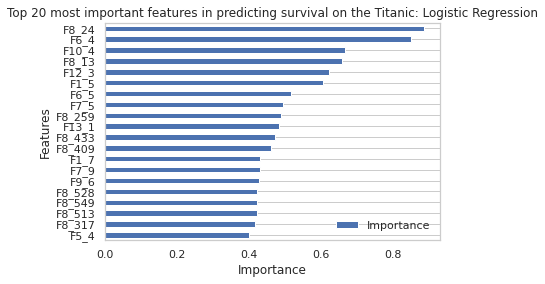

In [143]:
# log : 데이터 프레임 만들기
fi = {'Features':train.columns.tolist(), 'Importance':np.transpose(log.coef_[0])}
importance = pd.DataFrame(fi, index=fi['Features']).sort_values('Importance', ascending=True)

# 그래프 타이틀
title = 'Top 20 most important features in predicting survival on the Titanic: Logistic Regression'

# 그래프 그리기
importance_plotting(importance, 'Importance', 'Features',title, 20)

In [144]:
# 5가지 모델에 대한 항목 중요도 얻기
gbc_imp = pd.DataFrame({'Feature':train.columns, 'gbc importance':gbc.feature_importances_})
xgb_imp = pd.DataFrame({'Feature':train.columns, 'xgb importance':xgb.feature_importances_})
ran_imp = pd.DataFrame({'Feature':train.columns, 'ran importance':ran.feature_importances_})
ext_imp = pd.DataFrame({'Feature':train.columns, 'ext importance':ext.feature_importances_})
ada_imp = pd.DataFrame({'Feature':train.columns, 'ada importance':ada.feature_importances_})

# 하나의 데이터 프레임 만들기
importances = gbc_imp.merge(xgb_imp, on='Feature').merge(ran_imp, on='Feature').merge(ext_imp, on='Feature').merge(ada_imp, on='Feature')

# 항목당 평균 중요도
importances['Average'] = importances.mean(axis=1)

# 랭킹 정하기
importances = importances.sort_values(by='Average', ascen)

SyntaxError: ignored

### Part 8: 중요도에 따라 모델 재 설정

In [ ]:
fi = {'Features' : importances['Feature'], 'Importance':importances['Average']}
importance = pd.DataFrame(fi).set_index('Features').sort_values('Importance', ascending=True)

# 그래프 타이틀
title = 'Top 20 important features in predicting survival on the Titanic: 5 model average'

# 그래프 보기
importance_plotting(importance, 'Importance', 'Feature', title, 20)

In [ ]:
importance1 = importance[-381:]
importance1[378:381]

In [ ]:
# 영양가 있는 380개만 넣기

mylist = list(importance1.index)

In [ ]:
train1 = pd.DataFrame()
test1 = pd.DataFrame()

for i in mylist:
    train1[i] = train[i]
    test1[i] = test[i]

train1.head()

In [ ]:
train = train1
test = test1

# 모델의 변수를 다시 정의하고
X_train = train
X_test = test

# 바꿉니다.
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier(random_state=1)
gbc = GradientBoostingClassifier(random_state=1)
svc = SVC(probability=True)
ext = ExtraTreesClassifier(random_state=1)
ada = AdaBoostClassifier(random_state=1)
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier(random_state=1)

# 리스트 준비
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
model_names = ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier']
scores2 = {}

# 학습 및 교차 검증
for ind, mod in enumerate(models):
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 10)
    scores2[model_names[ind]] = acc

In [ ]:
# 결과 테이블을 만듭니다.
results = pd.DataFrame(scores2).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)#.reset_index()
result_df.head(11)
result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)');

### Part 9: 하이퍼 파라미터 튜닝

#### SVC
* Scikit-Learn에서는 3가지 모형 최적화 도구를 지원하는데 validation_curve/ GridSearchCV/ ParameterGrid이다
* fit 메소드를 호출하면 grid search가 자동으로 여러개의 내부 모형을 생성하고 이를 모두 실행시켜서 최적 파라미터를 찾는다.

* bestscore는 최고 점수이고 best estimator는 최고 점수를 낸 파라미터를 가진 모형
* c값과 gamma값은 10의 배수로 일반적으로 한다.
* 감마 매개 변수는 단일 학습 예제의 영향이 도달하는 정도를 정의하며 낮은 값은 'far'를, 높은 값은 'close'를 나타냅니다. 감마 매개 변수는 서포트 벡터로 모델에 의해 선택된 샘플의 영향 반경의 역으로 볼 수 있습니다.
* C 매개 변수는 의사 결정 표면의 단순성에 대한 훈련 예제의 오 분류를 제거합니다. C가 낮을수록 결정 표면이 매끄럽고 높은 C는 모델이 더 많은 샘플을 서포트 벡터로 자유롭게 선택할 수 있도록하여 모든 학습 예제를 올바르게 분류하는 것을 목표로합니다.
* Verbose는 불리안 값으로 True로 넣으면 꼬치 꼬치 다 알려주는데, 대신 시간이 좀 더 오래 걸립니다.
* cv =5는 5 fold로 교차 검증한다는 뜻입니다.

In [ ]:
# 파라미터 서치
Cs = [0.01, 0.1, 1, 5, 10, 15, 20, 50]
gammas = [0.001, 0.01, 0.1]

# 파라미터 그리드 셋팅
hyperparams = {'C': Cs, 'gamma' : gammas}

# 교차검증
gd=GridSearchCV(estimator = SVC(probability=True), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

# 모델 fiting 및 결과
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### Gradient Boosting Classifier
* learning_rate는 각 트리의 기여를 줄이는 역할을 합니다.
* n_estimator는 각 경우의 트리 숫자입니다.

In [ ]:
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5]
n_estimators = [100, 1000, 2000]
max_depth = [3, 5, 10, 15]

hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

gd=GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### Logistic Regression
* Penalty - L1 을 사용하는 회귀 모델을 Lasso Regression이라고하고 L2를 사용하는 모델을 Ridge Regression이라고합니다. 이 둘의 주요 차이점은 페널티입니다. 릿지 회귀는 손실 함수에 페널티 항으로 계수의 "제곱 크기"를 추가합니다. L2-norm이 오차를 제곱하기 때문에 (오류> 1 인 경우 로트가 증가 함) 모델은 L1-norm보다 훨씬 큰 오차 (e vs e ^ 2)를 보게되므로 훨씬 더 민감합니다. 따라서 오류를 최소화하기 위해 모델을 조정해줍니다.
* C는 estimator 입니다. logspace 1차원 10개 배열로 0에서 4까지를 estimator로 놓은 것입니다.

In [ ]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

hyperparams = {'penalty': penalty, 'C': C}

gd=GridSearchCV(estimator = LogisticRegression(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### XGBoost Step 1.

In [ ]:
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
n_estimators = [10, 50, 100, 250, 500, 1000]

hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

gd=GridSearchCV(estimator = XGBClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### XGB Step 2.

In [ ]:
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
min_child_weight = [1, 2, 3, 4, 5, 6]

hyperparams = {'max_depth': max_depth, 'min_child_weight': min_child_weight}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=10), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### XGB Step 3.

In [ ]:
gamma = [i*0.1 for i in range(0,5)]

hyperparams = {'gamma': gamma}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=10, max_depth=6, 
                                          min_child_weight=1), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### XGB Step 4

In [ ]:
subsample = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
colsample_bytree = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    
hyperparams = {'subsample': subsample, 'colsample_bytree': colsample_bytree}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=10, max_depth=6, 
                                          min_child_weight=1, gamma=0), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### XGB Step 5

In [ ]:
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
    
hyperparams = {'reg_alpha': reg_alpha}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=10, max_depth=6, 
                                          min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1),
                                         param_grid = hyperparams, verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### Gaussian Process

In [ ]:
n_restarts_optimizer = [0, 1, 2, 3]
max_iter_predict = [1, 2, 5, 10, 20, 35, 50, 100]
warm_start = [True, False]

hyperparams = {'n_restarts_optimizer': n_restarts_optimizer, 'max_iter_predict': max_iter_predict, 'warm_start': warm_start}

gd=GridSearchCV(estimator = GaussianProcessClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### Adaboost.

In [ ]:
n_estimators = [10, 100, 200, 500]
learning_rate = [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2]

hyperparams = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

gd=GridSearchCV(estimator = AdaBoostClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### KNN

In [ ]:
n_neighbors = [1, 2, 3, 4, 5]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = [1, 2, 3, 4, 5, 10]

hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}

gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### Random Forest.

In [ ]:
n_estimators = [10, 50, 100, 200]
max_depth = [3, None]
max_features = [0.1, 0.2, 0.5, 0.8]
min_samples_split = [2, 6]
min_samples_leaf = [2, 6]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

gd=GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### Extra Trees

In [ ]:
n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]
max_features = [0.1, 0.2, 0.5, 0.8]
min_samples_split = [2, 10]
min_samples_leaf = [2, 10]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

gd=GridSearchCV(estimator = ExtraTreesClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

#### Bagging Classifier

In [ ]:
n_estimators = [10, 50, 75, 100, 200]
max_samples = [0.1, 0.2, 0.5, 0.8, 1.0]
max_features = [0.1, 0.2, 0.5, 0.8, 1.0]

hyperparams = {'n_estimators': n_estimators, 'max_samples': max_samples, 'max_features': max_features}

gd=GridSearchCV(estimator = BaggingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

### Part 10: 모델 재 트레이닝

In [ ]:
# 튜닝 모델 시작
# sample을 split하는 것은 전체데이터 80%를 트레인셋에 20%는 테스트셋에 줌  
ran = RandomForestClassifier(max_depth=None, max_features=0.1, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=1)

knn = KNeighborsClassifier(leaf_size=1, n_neighbors=3, weights='distance')

log = LogisticRegression(C=59.94842503189409, penalty='l2')

xgb = XGBClassifier(learning_rate=0.2, n_estimators=10, max_depth=6, 
                                          min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1, reg_alpha=1e-05)

gbc = GradientBoostingClassifier(learning_rate=0.2, max_depth=3, n_estimators=1000)

svc = SVC(probability=True, gamma=0.001, C=1)

ext = ExtraTreesClassifier(max_depth=None, max_features=0.1, min_samples_leaf=2, min_samples_split=10, n_estimators=75, random_state=1)

ada = AdaBoostClassifier(learning_rate=1, n_estimators=200, random_state=1)

gpc = GaussianProcessClassifier(max_iter_predict=1, n_restarts_optimizer=0, warm_start=True)

bag = BaggingClassifier(max_features=0.5, max_samples=1.0, n_estimators=10, random_state=1)

# 리스트
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
model_names = ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier']
scores3 = {}

# Sequentially fit and cross validate all models
for ind, mod in enumerate(models):
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 10)
    scores3[model_names[ind]] = acc

In [ ]:
results = pd.DataFrame(scores).T
results['mean'] = results.mean(1)
result_df = results.sort_values(by='mean', ascending=False)
result_df.head(11)


result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')

### Part 11: 마지막 보팅

In [ ]:
#튜닝한 파라미터로 하드보팅
grid_hard = VotingClassifier(estimators = [('Random Forest', ran), 
                                           ('Logistic Regression', log),
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('Extra Trees', ext),
                                           ('AdaBoost', ada),
                                           ('Gaussian Process', gpc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn),
                                           ('Bagging Classifier', bag)], voting = 'hard')

grid_hard_cv = model_selection.cross_validate(grid_hard, X_train, y_train, cv=10)
grid_hard.fit(X_train, y_train)

print("Hard voting on test set score mean: {:.2f}". format(grid_hard_cv['test_score'].mean() * 100))

In [ ]:
grid_soft = VotingClassifier(estimators = [('Random Forest', ran), 
                                           ('Logistic Regression', log),
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('Extra Trees', ext),
                                           ('AdaBoost', ada),
                                           ('Gaussian Process', gpc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn),
                                           ('Bagging Classifier', bag)], voting = 'soft')

grid_soft_cv = model_selection.cross_validate(grid_soft, X_train, y_train, cv=10)
grid_soft.fit(X_train, y_train)

print("Soft voting on test set score mean: {:.2f}". format(grid_soft_cv['test_score'].mean() * 100))

### Part 12: 마지막 모델 예측

In [ ]:
# Final predictions2
predictions = grid_hard.predict(X_test)

submission = pd.concat([pd.DataFrame(passId), pd.DataFrame(predictions)], axis = 'columns')

submission.columns = ["PassengerId", "Survived"]
submission.to_csv('titanic_submission1.csv', header = True, index = False)

In [ ]:
# Final predictions
predictions = grid_soft.predict(X_test)

submission = pd.concat([pd.DataFrame(passId), pd.DataFrame(predictions)], axis = 'columns')

submission.columns = ["PassengerId", "Survived"]
submission.to_csv('titanic_submission2.csv', header = True, index = False)